# Predicting tips for each ride using New york Taxi data

## Importing all required libraries

In [52]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #pretty print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In this notebook, I will explore the data on New York City Taxi (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). I will start with some warm up questions about the dataset. Eventually, I will build a model to predict the percentage tip a driver would expect to receive on each trip. In this analysis, some notion of statistics and hypothesis test are used
## Warm up


***Let's first download the dataset and print out the its size***

In [53]:
# Download the New York City Taxi dataset

url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
data = pd.read_csv(url)
data.to_csv(url.split('/')[-1])

# Print the size of the dataset
print ("Number of rows:", data.shape[0])
print ("Number of columns: ", data.shape[1])

Number of rows: 1494926
Number of columns:  21


***Let's have a look at the distribution of trip distance***

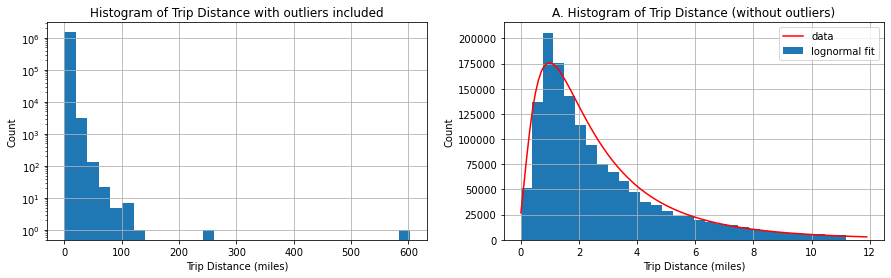

In [54]:
# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
data.Trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance with outliers included')

# create a vector to contain Trip Distance
v = data.Trip_distance 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v[~((v-v.median()).abs()>3*v.std())].hist(bins=30,ax=ax[1]) # 
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Distance (without outliers)')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(data.Trip_distance.values,
                               scale=data.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r') 
ax[1].legend(['data','lognormal fit'])
 
# export the figure
plt.savefig('Question2.jpeg',format='jpeg')
plt.show()


The Trip Distance is asymmetrically distributed. It is skewed to the right and it has a median smaller than its mean and both smaller than the standard deviation. The skewness is due to the fact that the variable has a lower boundary of 0. The distance can't be negative. [**This distribution has a structure of a lognormal distribution**](http://www.itl.nist.gov/div898/handbook/eda/section3/eda3669.htm). Plot on the left is the distribution of the entire raw set of Trip distance. To the right, outliers have been removed before plotting. *Outliers are defined as any point located further than 3 standard deviations from the mean*

**The hypothesis:** The trips are not random. If they were random, we would have a (symmetric) Gaussian distribution. The non-zero autocorrelation may be related to the fact that people taking taxi rides are pushed by a common cause, for instance, people rushing to work.

***Let's see if the time of the day has any impact on the trip distance***

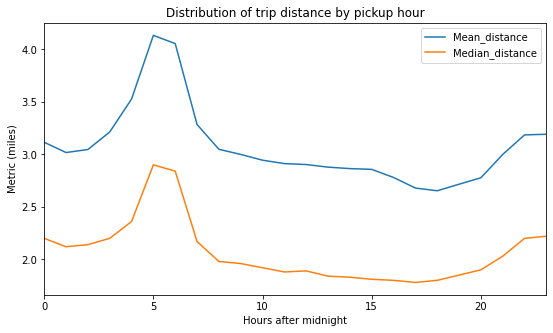

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.11528               2.2
     1          3.01735               2.12
     2          3.04618               2.14
     3          3.21295               2.2
     4          3.52656               2.36
     5          4.13347               2.9
     6          4.05515               2.84
     7          3.28439               2.17
     8          3.04845               1.98
     9          2.99911               1.96
    10          2.94448               1.92
    11          2.91202               1.88
    12          2.90306               1.89
    13          2.87829               1.84
    14          2.8643                1.83
    15          2.85704               1.81
    16          2.77985               1.8
    17          2.67911               1.78
    18          2.65322               1.8
    19          2.7156                1.85
    20         

In [55]:
# First, convert pickup and drop off datetime variable in their specific right format
data['Pickup_dt'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'] = data.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a variable for pickup hours
data['Pickup_hour'] = data.Pickup_dt.apply(lambda x:x.hour)

# Mean and Median of trip distance by pickup hour

fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values

# use a pivot table to aggregate Trip_distance by hour
table1 = data.pivot_table(index='Pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip distance by pickup hour')
#plt.xticks(np.arange(0,30,6)+0.35,range(0,30,6))
plt.xlim([0,23])
plt.savefig('Question3_1.jpeg',format='jpeg')
plt.show()

print ('-----Trip distance by hour of the day-----\n')
print (tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

We observe that long range trips majorly take place in the morning and evenings. Are these people commuting to work? If so how do they get back home. The evening peak is shorter than the morning peak. I would hypothesize that people are okay to take cabs in the morning to avoid being late to their early appointments while they would not mind taking public transportation in the evening. However, this might not apply to NYC.

***Let's also compare the trips that originate (or terminate) from (at) one of the NYC airports. We can look at how many there are, and the average fair, ...***

RateCodeID contains values indicating the final rate that was applied. Among those values, I realized that there is Newark and JFK which happens to be the major airports in New York ie. RateCodeID 2 (JFK) and 3 (Newark).

In [56]:
# select airport trips
airports_trips = data[(data.RateCodeID==2) | (data.RateCodeID==3)]
print ("Number of trips to/from NYC airports: ", airports_trips.shape[0])
print ("Average fare (calculated by the meter) of trips to/from NYC airports: $", airports_trips.Fare_amount.mean(),"per trip")
print ("Average total charged amount (before tip) of trips to/from NYC airports: $", airports_trips.Total_amount.mean(),"per trip")

Number of trips to/from NYC airports:  5552
Average fare (calculated by the meter) of trips to/from NYC airports: $ 48.976945244956774 per trip
Average total charged amount (before tip) of trips to/from NYC airports: $ 57.20842038904719 per trip


In addition to the number and mean fare of airport trips, let's also have a look at how trips are distributed by trip distances and hour of the day

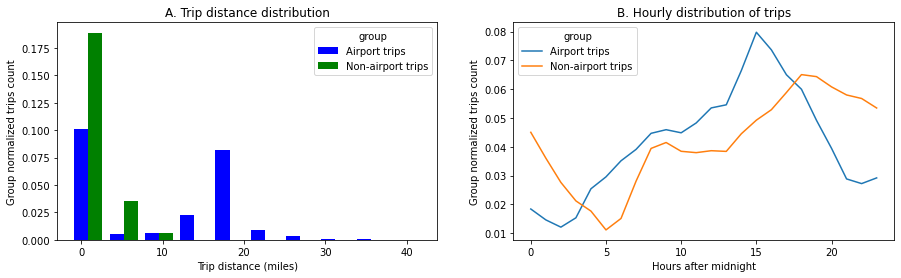

In [57]:
# create a vector to contain Trip Distance for
v2 = airports_trips.Trip_distance # airport trips
v3 = data.loc[~data.index.isin(v2.index),'Trip_distance'] # non-airport trips

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('A. Trip distance distribution')
#ax[0].set_yscale('log')

# plot hourly distribution
airports_trips.Pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
data.loc[~data.index.isin(v2.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B. Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')

plt.savefig('Question3_2.jpeg',format='jpeg')
plt.show()

A. The trip distance distribution shows two peaks. Airport trips follow the same trend as the rest of the trips for short trips (trip distance ≤ 2miles). However, there is also an increased number of long range trips (18 miles) which might correspond to a great number people coming to airports from further residential areas. A check on google map shows that the distance between JFK and Manhattan is about 18 miles whereas Newark to Manhattan is 15 miles.

B. The hourly distribution shows that the number of trips at airports peaks around 3PM. On the other hand, there is a shortage in airports riders at 2AM while the rest of NYC goes completely down 3 hours later 5AM.

## Predictive model
In this section, I am going to do my analysis for building a model to predict the percentage tip

***1. Let's build a derived variable for tip as a percentage of the total fare.***

Before we proceed with this, some cleaning is necessary. 
Since the [initial charge for NYC green taxi is $2.5](http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml), any transaction with a smaller total amount  is invalid, thus it is to be dropped


In [7]:
data = data[(data.Total_amount>=2.5)] #cleaning
data['Tip_percentage'] = 100*data.Tip_amount/data.Total_amount
print ("Summary: Tip percentage\n",data.Tip_percentage.describe())

Summary: Tip percentage
 count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


***2. Similarly for the comparison between trips to/from airports with the rest of the trips, it is worth to spend some time to check wether trips originating from upper manhattan have different percentage tip.***

To identify trips originating from upper manhattan:
- I have used google maps to collect latitude and longitude data of at least 12 points that approximately define the bounding box of upper Manhattan 
- Then I created a polygon using shapely.geometry.Polygon [https://pypi.python.org/pypi/Shapely]
- And checked if the polygon contains  a location defined by the (longitude, latitude)


In [8]:
# import library
from shapely.geometry import Point,Polygon,MultiPoint
# data points that define the bounding box of the Upper Manhattan
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function returns 1 if a location loc(lat,lon) is located inside a polygon of interest poi
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))
tic = dt.datetime.now()
# Create a new variable to check if a trip originated in Upper Manhattan
data['U_manhattan'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
print ("Processing time ", dt.datetime.now()-tic)

Processing time  0:00:23.437607


- Compare distributions of the two groups

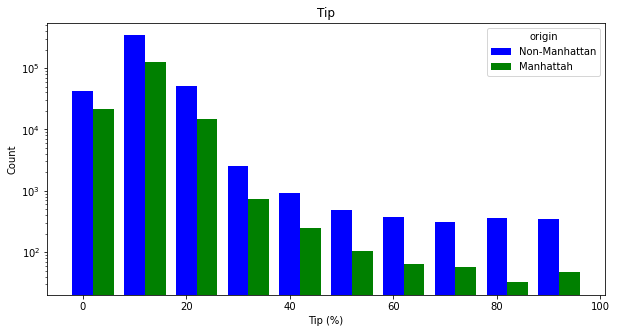

t-test results: Ttest_indResult(statistic=55.958566779306864, pvalue=0.0)


In [9]:
# create a vector to contain Tip percentage for
v1 = data[(data.U_manhattan==0) & (data.Tip_percentage>0)].Tip_percentage
v2 = data[(data.U_manhattan==1) & (data.Tip_percentage>0)].Tip_percentage

# generate bins and histogram values
bins = np.histogram(v1,bins=10)[1]
h1 = np.histogram(v1,bins=bins)
h2 = np.histogram(v2,bins=bins)


# generate the plot
# First suplot: visualize all data with outliers
fig,ax = plt.subplots(1,1,figsize=(10,5))
w = .4*(bins[1]-bins[0])
ax.bar(bins[:-1],h1[0],width=w,color='b')
ax.bar(bins[:-1]+w,h2[0],width=w,color='g')
ax.set_yscale('log')
ax.set_xlabel('Tip (%)')
ax.set_ylabel('Count')
ax.set_title('Tip')
ax.legend(['Non-Manhattan','Manhattah'],title='origin')
plt.show()
print ('t-test results:', ttest_ind(v1,v2,equal_var=False))

The two distributions look similar however the t-test results in a zero p-value and this implies that the two groups are different at 95% level of confidence

### The Model

#### Summary
The initial dataset contained 1494926 transactions with 21 time-series, categorical and numerical variables. In order to build the final model, I have broken down the process into 4 phases :
 (1) data cleaning 
 (2) feature engineering
 (3) exploratory data analysis and 
 (4) model creation

The cleaning consisted of dropping zero variance variables, replacing invalid values with the most frequently occurring values in each categorical variable whereas the median was used for continuous numerical variables. Invalid values could be missing values or values that are not allowed for specific variables. In this part, variables were also converted into their appropriate formats such datetime.

The feature engineering part created 10 new variables which were derived from pickup, drop-off locations, timestamps and trip distance.

During the exploration, each variable was carefully analyzed and compared to other variables and eventually with the target variable- Percentage tip. All numerical variables were found to follow log-normal or power law distributions although no linear relationship between numerical and the target variable was found. An interesting insight was uncovered in the distribution of the percentage tip. It was found that only 40% of the transactions paid tip. And 99.99% of these payments were done by credit cards. This motivated me to build a predictive model in two stages (1) classification model to find out whether a transaction will pay tip and (2) a regression model to find the percentage of the tip only if the transaction was classified as a tipper. Another insight was that, the most frequent percentage of tip is 18% which corresponds to the usual restaurant gratuity rate.

With lack of linear relationship between independent and dependent variables, the predictive model was built on top of the random forest regression and gradient boosting classifier algorithms implemented in sklearn after carrying out routines to optimize the parameters.


In [10]:

# Download dataset if not available on disk
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
data = pd.read_csv(url)
data.to_csv(url.split('/')[-1])

# Print the size of the dataset
print ("Number of rows:", data.shape[0])
print ("Number of columns: ", data.shape[1])

# create backup dataset
backup_data = data.copy()

Number of rows: 1494926
Number of columns:  21


#### 1. Data cleaning
Work done here deals with treating invalid data.

- Ehail_fee was removed since 99% of the data are missing
- Missing values in Trip_type were replaced with the most common value and that was 1
- Invalid data were found in:
    - RateCodeID: about 0.01% of the values were 99. These were replaced by the most common value 2
    - Extra: 0.08% of transactions had negative Extra. These were replaced by 0 as the most frequent
    - Total_amount, Fare_amount, improvement_surcharge, Tip_amount: 0.16% of values were negative. The cases were considered as being machine errors during the data entry. They were replaced by their absolute values. Furthermore, as the minimum Total_amount that is chargeable for any service is $2.5, every transaction falling below that amount was replaced by the median value of the Total_amount 11.76.


In [63]:
# define a function to clean a loaded dataset

def clean_data(adata):
    """
    This function cleans the input dataframe adata:
    . drop Ehail_fee [99% transactions are NaNs]
    . impute missing values in Trip_type
    . replace invalid data by most frequent value for RateCodeID and Extra
    . encode categorical to numeric
    . rename pickup and dropoff time variables (for later use)
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    ## make a copy of the input
    data = adata.copy()
    ## drop Ehail_fee: 99% of its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)

    ##  replace missing values in Trip_type with the most frequent value 1
    data['Trip_type '] = data['Trip_type '].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    # remove negative values from Total amount and Fare_amount
    print ("Negative values found and replaced by their abs")
    print ("Total_amount", 100*data[data.Total_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Fare_amount", 100*data[data.Fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    print ("Tip_amount", 100*data[data.Tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Tolls_amount", 100*data[data.Tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("MTA_tax", 100*data[data.MTA_tax<0].shape[0]/float(data.shape[0]),"%")
    data.Total_amount = data.Total_amount.abs()
    data.Fare_amount = data.Fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.Tip_amount = data.Tip_amount.abs()
    data.Tolls_amount = data.Tolls_amount.abs()
    data.MTA_tax = data.MTA_tax.abs()
    
    # RateCodeID
    indices_oi = data[~((data.RateCodeID>=1) & (data.RateCodeID<=6))].index
    data.loc[indices_oi, 'RateCodeID'] = 2 # 2 = Cash payment was identified as the common method
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 2")
    
    # Extra
    indices_oi = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
    data.loc[indices_oi, 'Extra'] = 0 # 0 was identified as the most frequent value
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Extra were invalid.--> Replaced by the most frequent 0")
    
    # Total_amount: the minimum charge is 2.5, so I will replace every thing less than 2.5 by the median 11.76 (pre-obtained in analysis)
    indices_oi = data[(data.Total_amount<2.5)].index
    data.loc[indices_oi,'Total_amount'] = 11.76
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 1.76")
    
    # encode categorical to numeric (I avoid to use dummy to keep dataset small)
    if data.Store_and_fwd_flag.dtype.name != 'int64':
        data['Store_and_fwd_flag'] = (data.Store_and_fwd_flag=='Y')*1
    
    # rename time stamp variables and convert them to the right format
    print ("renaming variables...")
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt','Lpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    print ("converting timestamps variables to right format ...")
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    
    print ("Done cleaning")
    return data
    

In [64]:
# Run code to clean the data
data = clean_data(data)

Negative values found and replaced by their abs
Total_amount 0.16168024370437065 %
Fare_amount 0.16168024370437065 %
Improvement_surcharge 0.14816786917880886 %
Tip_amount 0.002541931841442319 %
Tolls_amount 0.0004682506023709535 %
MTA_tax 0.14629486676932504 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 2
0.08 % of values in Extra were invalid.--> Replaced by the most frequent 0
0.32 % of values in total amount worth <$2.5.--> Replaced by the median 1.76
renaming variables...
converting timestamps variables to right format ...
Done cleaning


#### 2. Feature engineering
This step involved creating new variables derived from current variables. 

- **Time variables**: Week, Month_day(Day of month), Week_day (Day of week), Hour (hour of day), Shift_type (shift period of the day) and Trip_duration.These were created under the hypothesis that people may be willing to tip depending on the week days or time of the day. For instance, people are more friendly and less stressful, over the weekend and hence end up tipping more. They were derived from pickup time
- **Trip directions**: Direction_NS (is the cab moving North to South?) and Direction_EW (is the cab moving East to West). These are components of the two main directions, horizontal and vertical. The hypothesis is that the traffic may be different in different directions and it may affect the rider's enthusiasm for tipping. They were derived from pickup and drop-off coordinates
- **Speed**: ratio of Trip_distance to Trip_duration. At this level, all entries with speeds higher than 240 mph were dropped since this is the typical highest speed for cars commonly used as taxi [in addition to the fact that the speed limit in NYC is 50 mph](http://nytrafficticket.com/fastest-road-in-america-and-maximum-speed-limits-in-new-york/). An alternative filter threshold would be the highest posted speed limit in NYC but it might be sometimes violated.
- **With_tip**: This is to identify transactions with tips or not. This variable was created after discovering that 60% of transactions have 0 tip.
- As seen that using the mean of trips from Manhattan is different from the mean from other boroughs, this variable can be considered as well in the model building. A further and deep analysis, would be to required to create a variable of the origin and destination of each trip. This was tried but it was computationally excessive as the dataset only contains longitude and latitude data for each ride.

In [65]:
# Function to run the feature engineering
def engineer_features(adata):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . Shift type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day  
    . Speed_mph: float, speed of the trip
    . Tip_percentage: float, target variable
    . With_tip: int {0,1}, 1 = transaction with tip, 0 transction without tip
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = adata.copy()
    
    # derive time variables
    print ("deriving time variables...")
    ref_week = dt.datetime(2015,9,1).isocalendar()[1] # first week of september in 2015
    data['Week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week+1
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
    #data.rename(columns={'Pickup_hour':'Hour'},inplace=True)

    # create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
    data['Shift_type'] = np.NAN
    data.loc[data[(data.Hour>=7) & (data.Hour<15)].index,'Shift_type'] = 1
    data.loc[data[(data.Hour>=15) & (data.Hour<23)].index,'Shift_type'] = 2
    data.loc[data[data.Shift_type.isnull()].index,'Shift_type'] = 3
    
    # Trip duration 
    print ("deriving Trip_duration...")
    data['Trip_duration'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    print ("deriving direction variables...")
    # create direction variable Direction_NS. 
    # This is 2 if taxi moving from north to south, 1 in the opposite direction and 0 otherwise
    data['Direction_NS'] = (data.Pickup_latitude>data.Dropoff_latitude)*1+1
    indices = data[(data.Pickup_latitude == data.Dropoff_latitude) & (data.Pickup_latitude!=0)].index
    data.loc[indices,'Direction_NS'] = 0

    # create direction variable Direction_EW. 
    # This is 2 if taxi moving from east to west, 1 in the opposite direction and 0 otherwise
    data['Direction_EW'] = (data.Pickup_longitude>data.Dropoff_longitude)*1+1
    indices = data[(data.Pickup_longitude == data.Dropoff_longitude) & (data.Pickup_longitude!=0)].index
    data.loc[indices,'Direction_EW'] = 0
    
    # create variable for Speed
    print ("deriving Speed. Make sure to check for possible NaNs and Inf vals...")
    data['Speed_mph'] = data.Trip_distance/(data.Trip_duration/60)
    # replace all NaNs values and values >240mph by a values sampled from a random distribution of 
    # mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution
    indices_oi = data[(data.Speed_mph.isnull()) | (data.Speed_mph>240)].index
    data.loc[indices_oi,'Speed_mph'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
    print ("Feature engineering done! :-)")
    
    # Create a new variable to check if a trip originated in Upper Manhattan
    print ("checking where the trip originated...")
    data['U_manhattan'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
    
    # create tip percentage variable
    data['Tip_percentage'] = 100*data.Tip_amount/data.Total_amount
    
    # create with_tip variable
    data['With_tip'] = (data.Tip_percentage>0)*1

    return data


# collected bounding box points
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function checks if a location loc with lat and lon is located within the polygon of interest
    input:
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))


In [66]:
# run the code to create new features on the dataset
print ("size before feature engineering:", data.shape)
data = engineer_features(data)
print ("size after feature engineering:", data.shape)

size before feature engineering: (1494926, 20)
deriving time variables...
deriving Trip_duration...
deriving direction variables...
deriving Speed. Make sure to check for possible NaNs and Inf vals...
Feature engineering done! :-)
checking where the trip originated...
size after feature engineering: (1494926, 32)


In [15]:
# Uncomment to check for data validity. 
# data.describe() .T

#### 3. Exploratory Data Analysis
This was the key phase of the analysis. A look at the distribution of the target variable, "Tip_percentage" showed that 60% of all transactions did not give tip as in left figure below. And tip at 18% corresponds to the usual NYC customary gratuity rate which fluctuates between 18% and 25% (see Figure below,right). Based on this information, the model can be built in two steps

1. Create classification model to predict whether tip will be given or not. Here a new variable "With_tip" equals 1 (if there is tip) and 0 (otherwise) was created.
2. Create regression model for transactions with non-zero tip

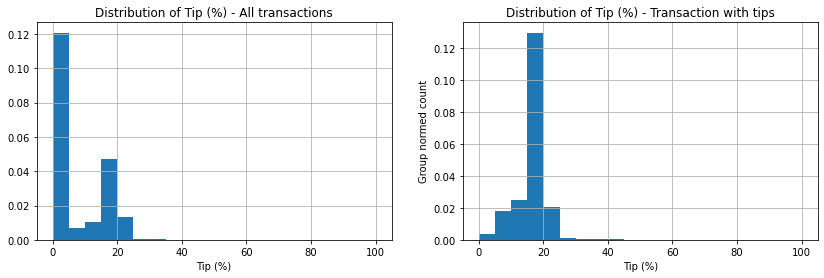

Transaction with tips:  40.32105937016281
Transaction wihtout tips:  59.67894062983719


In [74]:
## code to compare the two Tip_percentage identified groups
# split data in the two groups
data1 = data[data.Tip_percentage>0]
data2 = data[data.Tip_percentage==0]

# generate histograms to compare
fig,ax=plt.subplots(1,2,figsize=(14,4))
data.Tip_percentage.hist(bins = 20,ax=ax[0],density=True, stacked=True)
ax[0].set_xlabel('Tip (%)')
ax[0].set_title('Distribution of Tip (%) - All transactions')

data1.Tip_percentage.hist(bins = 20,ax=ax[1],density=True, stacked=True)
ax[1].set_xlabel('Tip (%)')
ax[1].set_title('Distribution of Tip (%) - Transaction with tips')
ax[1].set_ylabel('Group normed count')
plt.savefig('Question4_target_varc.jpeg',format='jpeg')
plt.show()


print("Transaction with tips: ",(data1.shape[0]/data.shape[0])*100)
data1 = data[data.Tip_percentage>0]
print("Transaction wihtout tips: ",(data2.shape[0]/data.shape[0])*100)

Next, each variable distribution and its relationship with the Tip percentage were explored. Few functions were implemented to quickly explore those variables:

In [17]:
# Functions for exploratory data analysis
def visualize_continuous(df,label,method={'type':'histogram','bins':20},outlier='on'):
    """
    function to quickly visualize continuos variables
    df: pandas.dataFrame 
    label: str, name of the variable to be plotted. It should be present in df.columns
    method: dict, contains info of the type of plot to generate. It can be histogram or boxplot [-Not yet developped]
    outlier: {'on','off'}, Set it to off if you need to cut off outliers. Outliers are all those points
    located at 3 standard deviations further from the mean
    """
    # create vector of the variable of interest
    v = df[label]
    # define mean and standard deviation
    m = v.mean()
    s = v.std()
    # prep the figure
    fig,ax = plt.subplots(1,2,figsize=(14,4))
    ax[0].set_title('Distribution of '+label)
    ax[1].set_title('Tip % by '+label)
    if outlier=='off': # remove outliers accordingly and update titles
        v = v[(v-m)<=3*s]
        ax[0].set_title('Distribution of '+label+'(no outliers)')
        ax[1].set_title('Tip % by '+label+'(no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins = method['bins'],ax=ax[0])
    if method['type'] == 'boxplot': # plot the box plot
        df.loc[v.index].boxplot(label,ax=ax[0])
    ax[1].plot(v,df.loc[v.index].Tip_percentage,'.',alpha=0.4)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Tip (%)')

def visualize_categories(df,catName,chart_type='histogram',ylimit=[None,None]):
    """
    This functions helps to quickly visualize categorical variables. 
    This functions calls other functions generate_boxplot and generate_histogram
    df: pandas.Dataframe
    catName: str, variable name, it must be present in df
    chart_type: {histogram,boxplot}, choose which type of chart to plot
    ylim: tuple, list. Valid if chart_type is histogram
    """
    print (catName)
    cats = sorted(pd.unique(df[catName]))
    if chart_type == 'boxplot': #generate boxplot
        generate_boxplot(df,catName,ylimit)
    elif chart_type == 'histogram': # generate histogram
        generate_histogram(df,catName)
    else:
        pass
    
    #=> calculate test statistics
    groups = df[[catName,'Tip_percentage']].groupby(catName).groups #create groups
    tips = df.Tip_percentage
    if len(cats)<=2: # if there are only two groups use t-test
        print (ttest_ind(tips[groups[cats[0]]],tips[groups[cats[1]]]))
    else: # otherwise, use one_way anova test
        # prepare the command to be evaluated
        cmd = "f_oneway("
        for cat in cats:
            cmd+="tips[groups["+str(cat)+"]],"
        cmd=cmd[:-1]+")"
        print ("one way anova test:", eval(cmd)) #evaluate the command and print
    print ("Frequency of categories (%):\n",df[catName].value_counts(normalize=True)*100)
    
def test_classification(df,label,yl=[0,50]):
    """
    This function tests if the means of the two groups with_tip and without_tip are different at 95% confidence level.
    It will also generate a box plot of the variable by tipping groups
    label: str, label to test
    yl: tuple or list (default = [0,50]), y limits on the ylabel of the boxplot
    df: pandas.DataFrame (default = data)
    
    Example: run <visualize_continuous(data,'Fare_amount',outlier='on')>
    """
    
    if len(pd.unique(df[label]))==2: #check if the variable is categorical with only two  categores and run chisquare test
        vals=pd.unique(df[label])
        gp1 = df[df.With_tip==0][label].value_counts().sort_index()
        gp2 = df[df.With_tip==1][label].value_counts().sort_index()
        print ("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print (chisquare(gp1,gp2))
    elif len(pd.unique(df[label]))>=10: #other wise  run the t-test
        df.boxplot(label,by='With_tip')
        plt.ylim(yl)
        plt.show()
        print ("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        # print ("results:",ttest_ind(df[df.With_tip==0][label].values, df[df.With_tip==1][label].values,False))
        print ("results:",ttest_ind(df.query('With_tip==0')[label].astype(int), df.query('With_tip== 1')[label].astype(int),equal_var=False))
        # data[data.Week==weeks[i]].Speed_mph
        
    else:
        pass

def generate_boxplot(df,catName,ylimit):
    """
    generate boxplot of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    df.boxplot('Tip_percentage',by=catName)
    #plt.title('Tip % by '+catName)
    plt.title('')
    plt.ylabel('Tip (%)')
    if ylimit != [None,None]:
        plt.ylim(ylimit)
    plt.show()

def generate_histogram(df,catName):
    """
    generate histogram of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    cats = sorted(pd.unique(df[catName]))
    colors = plt.cm.jet(np.linspace(0,1,len(cats)))
    # hx = np.array(map(lambda x:round(x,1),np.histogram(df.Tip_percentage,bins=20)[1]))
    hx = list(map(lambda x:np.round(x,1),np.histogram(df.Tip_percentage,bins=20)[1]))
 
    print("list(hx): ", list(hx))
    print(type(hx))
    fig,ax = plt.subplots(1,1,figsize = (15,4))
    for i,cat in enumerate(cats):
        vals = df[df[catName] == cat].Tip_percentage
        h = np.histogram(vals,bins=list(hx))
        w = 0.9*(hx[1]-hx[0])/float(len(cats))
        plt.bar(hx[:-1]+w*i,h[0],color=colors[i],width=w)
    plt.legend(cats)
    plt.yscale('log')
    plt.title('Distribution of Tip by '+catName)
    plt.xlabel('Tip (%)')

Starting with continuous variables, two main insights were discovered: A log-normal-like or power law distribution of the Fare amount and a non-linear function of the tip percentage as function of the total amount. The tip percentage decreases as the fare amount increases but converges around 20%. The density of scattered points implies that there is a high frequency of smaller tips at low Fare_amount. We can say that people restrain themselves from tipping more money as the cost of the ride becomes more and more expensive. Or since the fare grows with the length of the trip and trip duration, we can say that the riders get bored and don't appreciate the service they are getting. Many questions can be explored at this point

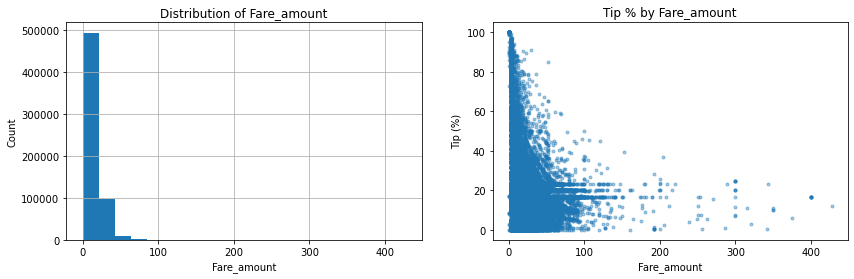

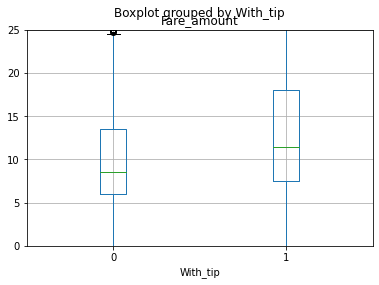

t-test if Fare_amount can be used to distinguish transaction with tip and without tip
results: Ttest_indResult(statistic=-164.56738872034734, pvalue=0.0)


In [18]:
# Example of exploration of the Fare_amount using the implented code:
visualize_continuous(data1,'Fare_amount',outlier='on')
test_classification(data,'Fare_amount',[0,25])

A negative t-test value and null p-value implies that the mean of Total_amount is significantly different in the group of transactions with tips compared to the group with no tip. Therefore, this variable would be useful to train the classification model.

Using the same function, a plot of the tip percentage as function of trip duration showed a cluster of points at duration time greater than 1350 min (22 hours). 
These points look like outliers since it doesn't make sense to have a trip of 22 hours within NYC. Probably, tourists can! 

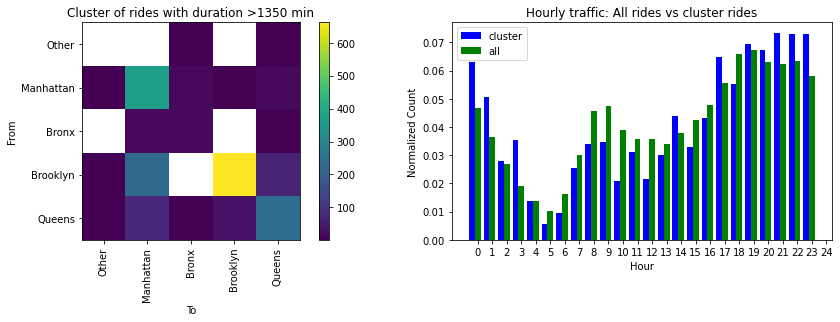

In [19]:
# Code to generate the heat map to uncover hidden information in the cluster
# We will first source NYC boroughs shape files, 
# then create polygons and check to which polygon does each of the point of the cluster begongs

## download geojson of NYC boroughs
nyc_boros = json.loads(requests.get("https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson").content)

# parse boros into Multipolygons
boros = {}
for f in nyc_boros['features']:
    name = f['properties']['BoroName']
    code = f['properties']['BoroCode']
    polygons = []
    for p in f['geometry']['coordinates']:
        polygons.append(Polygon(p[0]))
    boros[code] = {'name':name,'polygon':MultiPolygon(polygons=polygons)}
    
# creae function to assign each coordinates point to its borough
def find_borough(lat,lon):
    """
    return the borough of a location given its latitude and longitude
    lat: float, latitude
    lon: float, longitude
    """
    boro = 0 # initialize borough as 0
    for k,v in boros.items(): # update boro to the right key corresponding to the parent polygon
        if v['polygon'].contains(Point(lon,lat)):
            boro = k
            break # break the loop once the borough is found
    return [boro]

## Analyse the cluster now
# create data frame of boroughs
df = data1[data1.Trip_duration>=1350]
orig_dest = []
for v in df[['Pickup_latitude','Pickup_longitude','Dropoff_latitude','Dropoff_longitude']].values:
    orig_dest.append((find_borough(v[0],v[1])[0],find_borough(v[2],v[3])[0]))
df2 = pd.DataFrame(orig_dest)

## create pivot table for the heat map plot
df2['val']=1 # dummy variable
mat_cluster1 = df2.pivot_table(index=0,columns=1,values='val',aggfunc='count')

## generate the map
fig,ax = plt.subplots(1,2,figsize=(15,4))
im = ax[0].imshow(mat_cluster1)
ax[0].set_ylabel('From')
ax[0].set_xlabel('To')
ax[0].set_xticklabels(['','Other','Manhattan','Bronx','Brooklyn','Queens'],rotation='vertical')
ax[0].set_yticklabels(['','Other','Manhattan','Bronx','Brooklyn','Queens'])
ax[0].set_title('Cluster of rides with duration >1350 min')
fig.colorbar(im,ax=ax[0])
h = df.Hour.value_counts(normalize=True)
plt.bar(h.index,h.values,width = .4,color='b')
h = data1.Hour.value_counts(normalize=True)
ax[1].bar(h.index+.4,h.values,width = .4,color='g')
ax[1].set_title('Hourly traffic: All rides vs cluster rides')
ax[1].legend(['cluster','all'],loc='best')
ax[1].set_xlabel('Hour')
ax[1].set_xticks(np.arange(25)+.4,range(25))
ax[1].set_ylabel('Normalized Count')
plt.savefig('duration_cluster.jpeg',format='jpeg')
plt.show()

The heat map color represents the number of trips between two given boroughs. We can see that the majority of trips  are intra-boroughs. There is a great number of trips from Brooklyn to Manhattan whereas there is no Staten Island trip that takes more than 1350 minutes. Are there specific hours for these events? Unfortunately, the distribution on the right shows that the cluster behaves the same as the rest of the traffic.

Finally, correlation heatmap was used to find which independent variables are correlated to each other. The following code provides the construction of the correlation heatmap

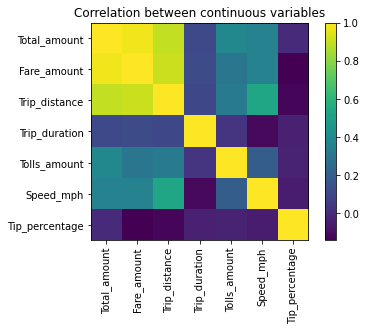

In [20]:
continuous_variables=['Total_amount','Fare_amount','Trip_distance','Trip_duration','Tolls_amount','Speed_mph','Tip_percentage']
cor_mat = data1[continuous_variables].corr()
#fig,ax = plt.subplots(1,1,figsize = [6,6])
plt.imshow(cor_mat)
plt.xticks(range(len(continuous_variables)),continuous_variables,rotation='vertical')
plt.yticks(range(len(continuous_variables)),continuous_variables)
plt.colorbar()
plt.title('Correlation between continuous variables')
plt.show()
#print cor_mat

*** Further analysis of all continuous variables revealed similar log-normal and non-linear behaviors. Since there is no linear relationship between the the Tip percentage and variables, random forest algorithm should be a better choice to build the regression part of the model***

As far as categorical variables are concerned, the function visualize_categories was used to explore each variable as it was done for continuous numerical variables

U_manhattan


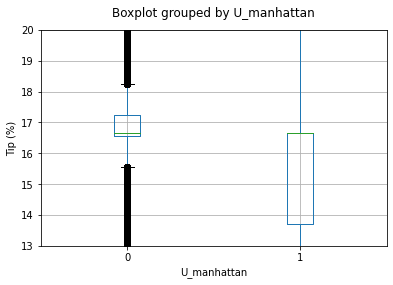

Ttest_indResult(statistic=52.88979199536133, pvalue=0.0)
Frequency of categories (%):
 0    73.053072
1    26.946928
Name: U_manhattan, dtype: float64


In [21]:
# exploration of the U_manhattan (trip originating from Upper Manhattan) variable 
visualize_categories(data1,'U_manhattan','boxplot',[13,20])

Payment_type
list(hx):  [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]
<class 'list'>
one way anova test: F_onewayResult(statistic=122.42820678634747, pvalue=2.850585804911125e-79)
Frequency of categories (%):
 1    99.993364
3     0.005807
4     0.000498
2     0.000332
Name: Payment_type, dtype: float64


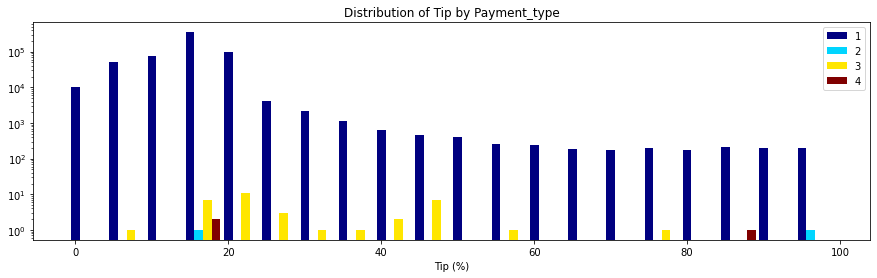

In [22]:
# visualization of the Payment_type
visualize_categories(data1,'Payment_type','histogram',[13,20])

This distribution shows that 99.99% transactions with tips were paid by Credit Card (method 1). This variable is not a good candidate for the regression model because of this unbalanced frequency but it is eventually an important feature to use in the classification model. An intuitive rule would be that if a rider is not paying with a credit card, there will be no tip.

Similar analysis were carried on every variable in order to find the most important variables with enough variance for either the regression model and/or classification model. 

This visual exploration analysis and statistical tests section concluded by selecting Total_amount, Fare_amount, Trip_distance, Tolls_amount, Trip_duration, Speed_mph, U_manhattan, Direction_NS and Direction_EW as initial important features to train and optimize the regression model. 
Payment_type, Passenger_count, Extra, Week_day, Hour, Direction_NS, Direction_EW, U_manhattan and Shift_type were selected as initial variables to train the classification model. 

#### 4. Building the Model

This model will be a combination of rules from two models (1) The classification model to classify a transaction into a tipper (=1) or not (=0)and (2) regression model to estimate the percentage of the tip given that the results from the classification model was 1

Functions for cross-validation and parameter optimization are defined below such that they can be used on either classification or regression algorithm

In [23]:
# import scikit learn libraries
from sklearn import metrics   #model optimization and valuation tools
# from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

# define a function that help to train models and perform cv
def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' by performing cross-validation. It works on both regression and classification
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cv or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print ("\nModel report:")
        if scoring_method == 'roc_auc':
            print ("Accuracy:",metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print ("AUC Score (Train):",metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        if (scoring_method == 'mean_squared_error'):
            print ("Accuracy:",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    if performCV:
        print ("CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()

# optimize n_estimator through grid search
def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn model,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    train: pandas.DataFrame, training data
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch

# plot optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.cv_results_[i][1],alg.cv_results_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# trees')
    plt.ylabel('score')
    plt.title('optimization report')

##### 4.1. Classification Model 
After spending some time on feature exploration, engineering and discovering that the Payment_type was a strong variable (99.99% of all transactions with tips were paid with credit cards) to differentiate transactions with tip from those without tip, a model based on the logistic regression classifier algorithm was optimized and this model gave an accuracy score of 0.94. However, this was outperformed by the GradientBoostingClassifier (from scikit learn) which gave a score of 0.96. Starting with the GradientBoostingClassier model (default parameters), the number of trees were optimized through the grid search mechanism.

*-- Key points --*:

- Sample size for training and optimization were chosen to be 100000. This is a small sample size compared to the available data but the optimization was stable and good enough with 5 folds cross-validation
- Only number of trees were optimized as they were the controlling key for boosting model accuracy. Other parameters were not optimized since the improvement yields were too small compared to the computation time and cost
- ROC-AUC (Area under the curve of receiver operating characteristic) was used as a model validation metric

*-- Results --*:

- optimized number of trees: 130
- optimized variables: ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax','Extra','Hour','Direction_NS', 'Direction_EW','U_manhattan']

The following code shows the optimization process

Optimizing the classifier...
{'mean_fit_time': array([ 2.43048277,  4.14786296,  5.979316  ,  7.81383271,  9.64196382,
       11.52160087, 13.64059381]), 'std_fit_time': array([0.11395128, 0.1639212 , 0.16150913, 0.16950025, 0.18496466,
       0.22314861, 0.35952687]), 'mean_score_time': array([0.01571264, 0.02295804, 0.03207331, 0.04056187, 0.04888997,
       0.05671263, 0.06543579]), 'std_score_time': array([0.00109419, 0.00026242, 0.00040615, 0.00035002, 0.00029521,
       0.00052118, 0.0017126 ]), 'param_n_estimators': masked_array(data=[30, 50, 70, 90, 110, 130, 150],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 30}, {'n_estimators': 50}, {'n_estimators': 70}, {'n_estimators': 90}, {'n_estimators': 110}, {'n_estimators': 130}, {'n_estimators': 150}], 'split0_test_score': array([0.98934341, 0.99385439, 0.99566981, 0.99652578, 0.99711911,
       0.99737869, 0.99755802]), 'split1_tes

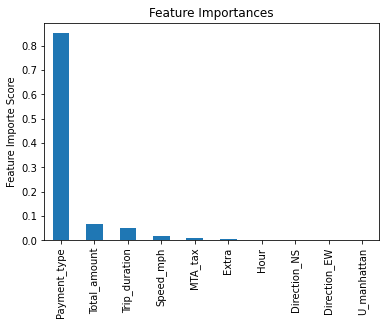

Processing time: 0:04:04.130217


In [24]:
## OPTIMIZATION & TRAINING OF THE CLASSIFIER

from sklearn.ensemble import GradientBoostingClassifier
print ("Optimizing the classifier...")

train = data.copy() # make a copy of the training set
# since the dataset is too big for my system, select a small sample size to carry on training and 5 folds cross validation
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]
target = 'With_tip' # set target variable - it will be used later in optimization

tic = dt.datetime.now() # initiate the timing
# for predictors start with candidates identified during the EDA
predictors = ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax',
              'Extra','Hour','Direction_NS', 'Direction_EW','U_manhattan']

# optimize n_estimator through grid search
param_test = {'n_estimators':range(30,151,20)} # define range over which number of trees is to be optimized


# initiate classification model
model_cls = GradientBoostingClassifier(
    learning_rate=0.1, # use default
    min_samples_split=2,# use default
    max_depth=5,
    max_features='auto',
    subsample=0.8, # try <1 to decrease variance and increase bias
    random_state = 10)

# get results of the search grid
gs_cls = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
print (gs_cls.cv_results_, gs_cls.best_params_, gs_cls.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc')

# save the best estimator on disk as pickle for a later use
with open('my_classifier.pkl','wb') as fid:
    pickle.dump(gs_cls.best_estimator_,fid)
    fid.close()
    
print ("Processing time:", dt.datetime.now()-tic)

The output shows that the optimum number of trees in 130 and that the important variables for this specific number of tree are as shown on the barchart. 

Let's test it on a different sample with the following code

In [25]:
# testing on a different set
indices = data.index[~data.index.isin(train.index)]
test = data.loc[np.random.choice(indices,size=100000,replace=False)]

ypred = gs_cls.best_estimator_.predict(test[predictors])

print ("ROC AUC:", metrics.roc_auc_score(ypred,test.With_tip))

ROC AUC: 0.967151256752693


##### 4.2 Regression Model 
Following a similar pipeline of optimization as in the classification model, a model was built on top of the random forest algorithm. 

*-- Key points --*:
- Sample size for training and optimization was chosen as 100000 with 5 folds cross-validation
- Only the number of trees were optimized as they are the controlling key of boosting model accuracy. Other parameters were not optimized since the improvement yield was too small compared to the computation time and cost
- The mean square error was used as a valuation metric

*-- Results --*:

- optimized number of trees: 150
- optimized variables: Total_amount, Trip_duration, Speed_mph


The following code shows the optimization process

{'mean_fit_time': array([ 8.22037654, 12.23458004, 16.62466564, 20.29772229, 25.40144219,
       29.54485574]), 'std_fit_time': array([0.08221077, 0.07334874, 0.23401054, 0.16943193, 0.69801238,
       1.20474069]), 'mean_score_time': array([0.20623765, 0.30209875, 0.41793814, 0.51198106, 0.86291685,
       0.81198292]), 'std_score_time': array([0.00973548, 0.01823405, 0.02961984, 0.06890808, 0.19834317,
       0.10697369]), 'param_n_estimators': masked_array(data=[50, 75, 100, 125, 150, 175],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 50}, {'n_estimators': 75}, {'n_estimators': 100}, {'n_estimators': 125}, {'n_estimators': 150}, {'n_estimators': 175}], 'split0_test_score': array([-17.16167621, -17.07500299, -16.87333475, -17.1529268 ,
       -16.8985441 , -16.90312308]), 'split1_test_score': array([-15.97613156, -15.3357546 , -15.79098006, -15.42608505,
       -15.43367517, -15.56427858]),

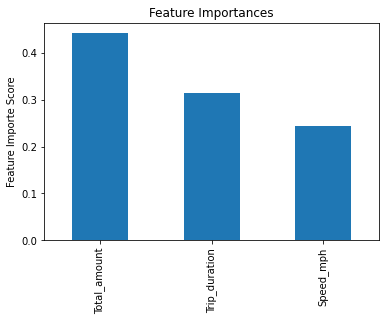

RFR test mse: 14.554700901498702
RFR r2: 0.2799979399067557
0:06:33.300085


In [26]:
train = data1.copy()
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]
indices = data1.index[~data1.index.isin(train.index)]
test = data1.loc[np.random.choice(indices,size=100000,replace=False)]

train['ID'] = train.index
IDCol = 'ID'
target = 'Tip_percentage'

predictors = ['VendorID', 'Passenger_count', 'Trip_distance', 'Total_amount', 
              'Extra', 'MTA_tax', 'Tolls_amount', 'Payment_type', 
              'Hour', 'U_manhattan', 'Week', 'Week_day', 'Month_day', 'Shift_type', 
              'Direction_NS', 'Direction_EW', 'Trip_duration', 'Speed_mph']
predictors = ['Trip_distance','Tolls_amount', 'Direction_NS', 'Direction_EW', 'Trip_duration', 'Speed_mph']
predictors = ['Total_amount', 'Trip_duration', 'Speed_mph']


# Random Forest
tic = dt.datetime.now()
from sklearn.ensemble import RandomForestRegressor
# optimize n_estimator through grid search
param_test = {'n_estimators':range(50,200,25)} # define range over which number of trees is to be optimized
# initiate classification model
#rfr = RandomForestRegressor(min_samples_split=2,max_depth=5,max_features='auto',random_state = 10)
rfr = RandomForestRegressor()#n_estimators=100)
# get results of the search grid
gs_rfr = optimize_num_trees(rfr,param_test,'neg_mean_squared_error',train,predictors,target)

# print optimization results
print (gs_rfr.cv_results_, gs_rfr.best_params_, gs_rfr.best_score_)

# plot optimization results
#plot_opt_results(gs_rfr)

# cross validate the best model with optimized number of estimators
modelfit(gs_rfr.best_estimator_,train,predictors,target,'neg_mean_squared_error')

# save the best estimator on disk as pickle for a later use
with open('my_rfr_reg2.pkl','wb') as fid:
    pickle.dump(gs_rfr.best_estimator_,fid)
    fid.close()

ypred = gs_rfr.best_estimator_.predict(test[predictors])

print ('RFR test mse:',metrics.mean_squared_error(ypred,test.Tip_percentage))
print ('RFR r2:', metrics.r2_score(ypred,test.Tip_percentage))
print (dt.datetime.now()-tic)
# plot_opt_results(gs_rfr)

The output shows that the optimum number of trees is 150 and that the important variables for this specific number of tree are as shown on the bar-chart. 

##### 4.3 Final Model 

This is a combination of the classification model and regression model in order to get the final predictions. The model was run on the entire dataset to predict expected tip percentages. It resulted in a mean squared error of 0.8793.

The process is as follow:
1. Get transaction to  predict
2. Classify the transaction into zero or non-zero tip
3. If the transaction is classified as non-zero, predict the tip percentage otherwise return 0

Next, I define a function that is to be used to make final predictions

In [27]:
def predict_tip(transaction):
    """
    This function predicts the percentage tip expected on 1 transaction
    transaction: pandas.dataframe, this should have been cleaned first and feature engineered
    """
    # define predictors labels as per optimization results
    cls_predictors = ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax',
                      'Extra','Hour','Direction_NS', 'Direction_EW','U_manhattan']
    reg_predictors = ['Total_amount', 'Trip_duration', 'Speed_mph']
    
    # classify transactions
    clas = gs_cls.best_estimator_.predict(transaction[cls_predictors])
    
    # predict tips for those transactions classified as 1
    return clas*gs_rfr.best_estimator_.predict(transaction[reg_predictors])



Make predictions on a sample of 100000 transactions

In [75]:
test = data.loc[np.random.choice(data.index,size = 100000,replace=False)]
ypred = predict_tip(test)
print ("Final mean_squared_error:", metrics.mean_squared_error(ypred,test.Tip_percentage))
print ("Final r2_score:", metrics.r2_score(ypred,test.Tip_percentage))

Final mean_squared_error: 8.279520430664464
Final r2_score: 0.8870057917255246


The results are pretty good for a black box model.

Finally, I plot the residuals.

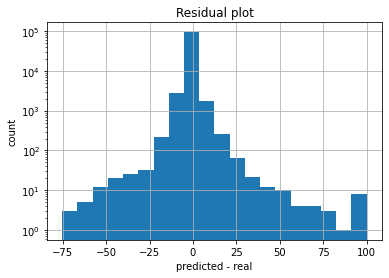

In [29]:
df = test.copy() # make a copy of data
df['predictions'] = ypred # add predictions column
df['residuals'] = df.Tip_percentage - df.predictions # calculate residuals

df.residuals.hist(bins = 20) # plot histogram of residuals
plt.yscale('log')
plt.xlabel('predicted - real')
plt.ylabel('count')
plt.title('Residual plot')
plt.show()

The residual is pretty much symmetrically distributed. This indicate that the model is equally biased. 

### Future Scope

- As for the future work, I would try to find a transformation function that can linearlize indipendent values. I would also optimize different algorithms such as extreme gradient boosting and make a bag of multiple models as a final model. 



This dataset is very rich in information and can be used to learn about other aspects of traffic in NYC as well. 

For example:

- We can derive a variable representing the average speed over the course of a trip and then perform a test to determine if the average speeds are esentially the same in all weeks of September. I use pairwise t-student test. The null hypothesis for t-test is that the mean is the same in two tested samples. We will see that the speed is not really different in all weeks. From the hypothesis test, we see that we don't have enough evidence that speeds are different in Week 2 and Week 3 are significantly different hence we fail to reject the null hypothesis at 95% level of confidence. The rest of the weeks have smaller p-values, so **we can reject the null hypothesis and say that they are significantly different. In general, the speed can be dependent on the week of the month.**

mean speed by week:
       Speed_mph
Week           
1     13.360173
2     12.690720
3     12.685760
4     13.162212
5     12.491761


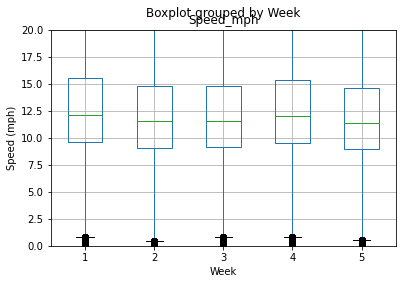

p-values:
 w1             1              2              3              4              5
w2                                                                          
1   1.000000e+00   0.000000e+00   0.000000e+00   1.175946e-28   0.000000e+00
2   0.000000e+00   1.000000e+00   7.607417e-01  7.804349e-174   2.049982e-19
3   0.000000e+00   7.607417e-01   1.000000e+00  5.978614e-181   9.937418e-19
4   1.175946e-28  7.804349e-174  5.978614e-181   1.000000e+00  5.757683e-198
5   0.000000e+00   2.049982e-19   9.937418e-19  5.757683e-198   1.000000e+00


In [34]:
print ("mean speed by week:\n", data[['Speed_mph','Week']].groupby('Week').mean())
# generate boxplot
data.boxplot('Speed_mph','Week')
plt.ylim([0,20]) # cut off outliers
plt.ylabel('Speed (mph)')
plt.show()

# calculate t-test
weeks = pd.unique(data.Week)
pvals = []
for i in range(len(weeks)): # for each pair, run t-test
    for j in range(len(weeks)):
        pvals.append((weeks[i], weeks[j],ttest_ind(data[data.Week==weeks[i]].Speed_mph,data[data.Week==weeks[j]].Speed_mph,equal_var= False)[1]))
    
pvalues = pd.DataFrame(pvals,columns=['w1','w2','pval'])
print ("p-values:\n",pvalues.pivot_table(index='w1',columns='w2',values='pval').T)

- Another interesting question is to analyse how the speed changes over the course of the day. In this case I use  one-way anova test on multiple samples. We find that the speed is different in different hours with a zero pvalue of the anova test. The boxplot reveals that traffic is faster early morning and gets really slow in the evening.

one way anova test: F_onewayResult(statistic=3383.546050356768, pvalue=0.0)


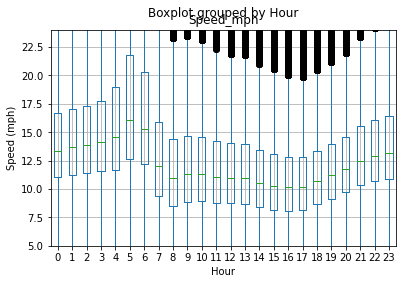

In [36]:
# calculate anova
hours = range(24)
cmd = "f_oneway("
for h in hours:
    cmd+="data[data.Hour=="+str(h)+"].Speed_mph,"
cmd=cmd[:-1]+")"
print ("one way anova test:", eval(cmd) )#evaluate the command and print

# boxplot
data.boxplot('Speed_mph','Hour')
plt.ylim([5,24]) # cut off outliers
plt.ylabel('Speed (mph)')
plt.show()

THE END